In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random
from tqdm import tnrange

In [2]:
from Models.DHead import DHead
from Models.Discriminator import Discriminator
from Models.QHead import QHead
from Models.Generator import Generator
from Utils import get_data, get_latent_input, initialize_weights

In [3]:
# set seed
seed = 134
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  134


In [4]:
# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

cuda:0  will be used.



In [5]:
# set noise parameters
num_z = 128
num_discrete = 10
discrete_dim = 10
batch_size = 128
# model hyperparameters
lr = 0.0002
betas = (0.5, 0.999)
n_epochs = 2

In [6]:
# get data
dataloader = get_data(path='../celeba/', batch_size=batch_size)

In [7]:
len(dataloader)

1583

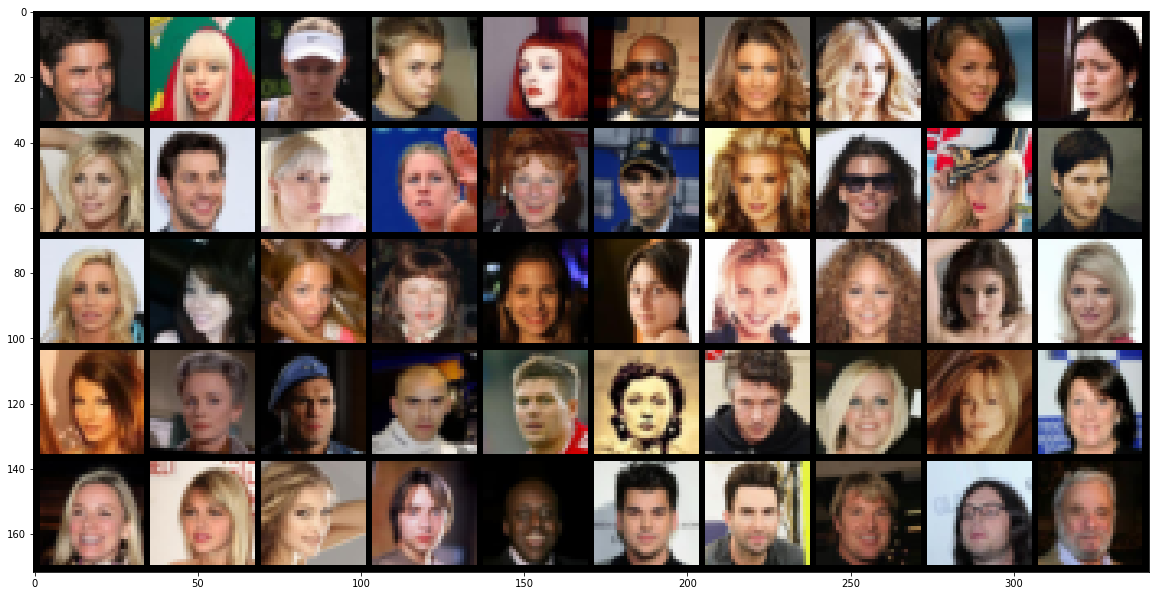

In [8]:
sample_batch = next(iter(dataloader))
plt.figure(figsize=(20, 15))
plt.imshow(np.transpose(vutils.make_grid(sample_batch[0].to(device)[ : 50], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()
plt.close('all')

In [9]:
Gen = Generator().to(device)
Gen.apply(initialize_weights)
print(Gen)

Generator(
  (conv_t1): ConvTranspose2d(228, 448, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t2): ConvTranspose2d(448, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv_t4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv_t5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [10]:
Disc = Discriminator().to(device)
Disc.apply(initialize_weights)
print(Disc)

Discriminator(
  (c1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (c2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (b2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [11]:
Dhead = DHead().to(device)
Dhead.apply(initialize_weights)
print(Dhead)

DHead(
  (conv): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
)


In [12]:
Qhead = QHead().to(device)
Qhead.apply(initialize_weights)
print(Qhead)

QHead(
  (c1): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
  (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c2): Conv2d(128, 100, kernel_size=(1, 1), stride=(1, 1))
)


In [13]:
# Loss function for discriminator
Disc_criterion = nn.BCELoss()
# Loss for discrete latent code
Q_criterion = nn.CrossEntropyLoss()

In [14]:
# discriminator optimizer
Discriminator_optim = optim.Adam([{'params': Disc.parameters()}, {'params': Dhead.parameters()}], lr=lr, betas=betas)
# Generator optimizer
Generator_optim = optim.Adam([{'params': Gen.parameters()}, {'params': Qhead.parameters()}], lr=lr, betas=betas)

In [15]:
# Generate Fixed Noise
# get discrete codes
idx = np.arange(discrete_dim).repeat(10)
discrete_codes = torch.zeros(size=(100, num_discrete, discrete_dim), device=device)
for i in range(num_discrete):
    discrete_codes[range(0, 100), i, idx] = 1.0
discrete_codes = discrete_codes.view(100, -1, 1, 1)
# get normal noise
normal_noise = torch.randn(100, num_z, 1, 1, device=device)

# Fixed noise
fixed_noise = torch.cat((normal_noise, discrete_codes), dim=1)

In [16]:
real_label = 1
fake_label = 0

In [17]:
# List variables to store results training.
img_list = []
G_losses = []
D_losses = []

In [19]:
# start training
num_epochs = 10
iters = 0

for epoch in range(num_epochs):
    for i in tnrange(1583):
        try:
            data, target = next(dataloader_iterator)
        except StopIteration:
            dataloader_iterator = iter(dataloader)
            data, _ = next(dataloader_iterator)
            
        # ------------------Real Data-----------------
        # get batch size
        batch_size = data.size(0)
        # transfer to device
        data = data.to(device)
        
        # Update discriminator and it's head
        Discriminator_optim.zero_grad()
        # get labels
        labels = torch.full(size=(batch_size,), fill_value=real_label, device=device)
        # get model predictions
        disc_preds_real = Disc.forward(data)
        # get probabilities
        real_probs = Dhead.forward(disc_preds_real).view(-1)
        # get discriminator loss
        real_loss = Disc_criterion(real_probs, labels)
        # backpropogate
        real_loss.backward()
        
        #------------------Generated Data----------------
        # get fake labels
        labels.fill_(fake_label)
        # get latent input
        latent_input, codes = get_latent_input(batch_size=batch_size, num_z=num_z, discrete_dim=discrete_dim,
                                               num_discrete=num_discrete, device=device)
        # generate images
        gen_data = Gen.forward(latent_input)
        # pass generated images through discriminator
        disc_preds_fake = Disc.forward(gen_data.detach())
        # get probabilities
        fake_probs = Dhead.forward(disc_preds_fake).view(-1)
        # get discriminator loss
        fake_loss = Disc_criterion(fake_probs, labels)
        # backpropogate
        fake_loss.backward()
        
        # Upadate discriminator weights
        disc_loss = real_loss + fake_loss
        Discriminator_optim.step()
        
        # Update generator and it's head 
        Generator_optim.zero_grad()
        
        # get discriminator preds for generated images
        disc_preds = Disc.forward(gen_data)
        # reset labels to train generator
        labels.fill_(real_label)
        # get probabilities
        probs = Dhead.forward(disc_preds).view(-1)
        # get generator loss
        gen_loss = Disc_criterion(probs, labels)
        # get generator head logits
        logits = Qhead.forward(disc_preds)
        # get target for logits
        target = torch.LongTensor(codes).to(device)
        # calculate loss for discrete latent code
        discrete_code_loss = 0
        for  j in range(num_discrete):
            discrete_code_loss += Q_criterion(logits[:, j*10: (j*10) + 10], target[j])
        # calculate net loss for generator
        gen_loss += discrete_code_loss
        # backpropogate
        gen_loss.backward()
        # update genrator weights
        Generator_optim.step()
        # check training progress
#         if i != 0 and i%100 == 0:
#             print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
#                   % (epoch+1, num_epochs, i, len(dataloader), 
#                     disc_loss.item(), gen_loss.item()))
        # Save the losses for plotting.
        G_losses.append(gen_loss.item())
        D_losses.append(disc_loss.item())
        
        iters += 1
        
    # generate image after each epoch to test generator
    with torch.no_grad():
        gen_data = Gen(fixed_noise).detach().cpu()
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
    plt.show()
    plt.close('all')
    # save network weights
    torch.save({
        'netG' : Gen.state_dict(),
        'discriminator' : Disc.state_dict(),
        'netD' : Dhead.state_dict(),
        'netQ' : Qhead.state_dict(),
        'optimD' : Discriminator_optim.state_dict(),
        'optimG' : Generator_optim.state_dict()
        }, 'checkpoint/model_CelebA')
    if (epoch+1)%5 == 0:
        torch.save({
            'netG' : Gen.state_dict(),
            'discriminator' : Disc.state_dict(),
            'netD' : Dhead.state_dict(),
            'netQ' : Qhead.state_dict(),
            'optimD' : Discriminator_optim.state_dict(),
            'optimG' : Generator_optim.state_dict()
            }, 'checkpoint/model_epoch_%d_{}'.format('CelebA') %(epoch+1))

KeyboardInterrupt: 

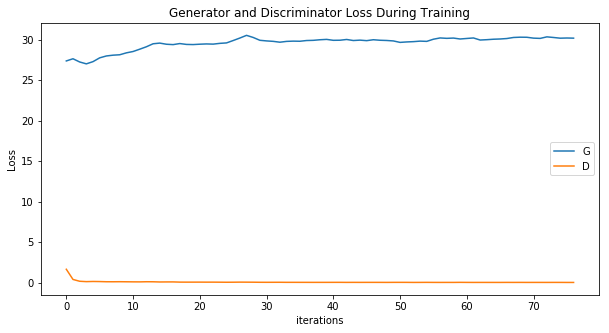

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator - Discriminator Training Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./Loss Curve")